In [2]:
%run "../utilities_general.py"

In [3]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Union


path_prefix = "/content/drive/MyDrive/Colab Notebooks/MachineLearning_Fermibot_DimensionalityReduction"
embeddings_file_path = f"{path_prefix}/df_embeddings.pkl"

N_FEATURES = 2048
TOP_K = 10

In [ ]:
df_embeddings = pd.read_pickle(embeddings_file_path).head(512)
array_start = np.array(df_embeddings["embeddings"].to_list())

In [ ]:
class PrincipalComponentAnalysis:
    def __init__(self, X, dim_in, dim_out: Union[int, List[int]]):
        self.X = X
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.projections = {}
        self.calculate_eigen()
        self.print_formatter = print_formatter


        if type(dim_out) == int:
          self.projections[dim_out] = self.project(dim_out)
        elif type(dim_out) == list:
          for dim in dim_out:
            self.projections[dim] = self.project(dim)
        else:
          raise ValueError("dim_out must be an integer or a list of integers")



    def calculate_eigen(self):

      self.X_mean = array_start.mean(axis=1)
      self.X_std = array_start.std(axis=1)

      self.X_norm = (self.X - self.X_mean[:, np.newaxis]) / self.X_std[:, np.newaxis]
      self.X_cov = np.cov(self.X_norm, rowvar=False)

      self.X_eigen_values, self.X_eigen_vectors = np.linalg.eigh(self.X_cov)


      assert self.X_norm.shape == self.X.shape
      assert self.X_norm.shape == (len(self.X), self.dim_in)
      assert self.X_cov.shape == (self.dim_in, self.dim_in)
      assert self.X_eigen_values.shape == (self.dim_in,)
      assert self.X_eigen_vectors.shape == (self.dim_in, self.dim_in)

    def project(self, dim_out):
      self.print_formatter(f"Projecting from {self.dim_in:04} to {dim_out:04}|Start")
      if dim_out > self.dim_in:
          raise ValueError("dim_out cannot be greater than dim_in")
      self.X_eigen_index_sorted = np.argsort(self.X_eigen_values)[::-1]
      self.X_eigen_values_sorted = self.X_eigen_values[self.X_eigen_index_sorted]
      self.X_eigen_vectors_sorted = self.X_eigen_vectors[:, self.X_eigen_index_sorted]
      self.X_eigen_vectors_sorted_top_k = self.X_eigen_vectors_sorted[:, :dim_out]
      assert self.X_eigen_vectors_sorted_top_k.shape == (self.dim_in, dim_out)
      assert self.X_eigen_vectors_sorted.shape == (self.dim_in, self.dim_in)
      assert self.X_eigen_values_sorted.shape == (self.dim_in,)
      projection = self.X_norm @ self.X_eigen_vectors_sorted_top_k
      assert projection.shape == (len(self.X), dim_out)
      self.print_formatter(f"Projecting from {self.dim_in:04} to {dim_out:04}|End\n", color="green")
      return projection

    def project_all(self):
      return self.project(self.dim_out)


pca = PrincipalComponentAnalysis(array_start, N_FEATURES, [2 ** x for x in range(2, 11)])

[2025-07-24 02:42:21] Projecting from 2048 to 0004|Start
[2025-07-24 02:42:21] Projecting from 2048 to 0004|End

[2025-07-24 02:42:21] Projecting from 2048 to 0008|Start
[2025-07-24 02:42:21] Projecting from 2048 to 0008|End

[2025-07-24 02:42:21] Projecting from 2048 to 0016|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0016|End

[2025-07-24 02:42:22] Projecting from 2048 to 0032|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0032|End

[2025-07-24 02:42:22] Projecting from 2048 to 0064|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0064|End

[2025-07-24 02:42:22] Projecting from 2048 to 0128|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0128|End

[2025-07-24 02:42:22] Projecting from 2048 to 0256|Start
[2025-07-24 02:42:22] Projecting from 2048 to 0256|End

[2025-07-24 02:42:22] Projecting from 2048 to 0512|Start
[2025-07-24 02:42:23] Projecting from 2048 to 0512|End

[2025-07-24 02:42:23] Projecting from 2048 to 1024|Start
[2025-07-24 02:42:23] Projecting from 2

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cosine_similarities = {}

def cosine_similarity_flattened(matrix):
  matrix = cosine_similarity(matrix)
  matrix_triangle_indices = np.triu_indices_from(matrix)
  matrix[matrix_triangle_indices] = np.nan
  matrix = matrix.flatten()
  matrix = matrix[~np.isnan(matrix)]
  return matrix


for dim in pca.projections.keys():
  cosine_similarities[f"PCA_{dim:04}"] = cosine_similarity_flattened(pca.projections[dim])

cosine_similarities[f"Original_2048"] = cosine_similarity_flattened(array_start)


cosine_similarities = pd.DataFrame(cosine_similarities)


path_prefix = "/content/drive/MyDrive/Colab Notebooks/MachineLearning_PrincipalComponentAnalysis"

cosine_similarities.to_csv(f"{path_prefix}/MachineLearning_PrincipalComponentAnalysis.csv")

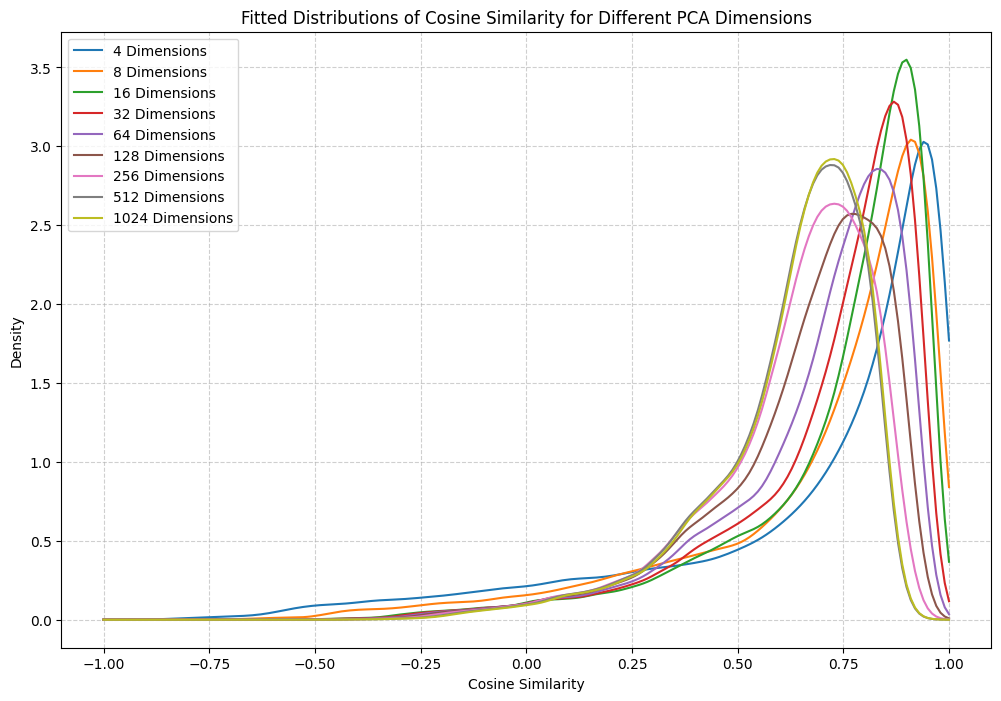

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

plt.figure(figsize=(12, 8)) # Adjust figure size for better readability

# Define a range for the x-axis for plotting the fitted curves
x_range = np.linspace(-1, 1, 200) # Cosine similarity is between -1 and 1

for dim, cosine_sim_matrix in cosine_similarities.items():
  # Flatten the cosine similarity matrix and remove NaN values
  data_hist = cosine_sim_matrix[~np.isnan(cosine_sim_matrix)].flatten()

  # Use a larger number of bins for KDE estimation
  kde = gaussian_kde(data_hist, bw_method='silverman') # Using 'scott' or 'silverman' can help with bandwidth selection
  pdf = kde(x_range)

  # Plot the fitted curve
  plt.plot(x_range, pdf, label=f'{dim} Dimensions') # Plot the PDF curve

plt.title('Fitted Distributions of Cosine Similarity for Different PCA Dimensions')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend() # Add a legend to identify dimensions
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability
plt.show()

In [ ]:
# Calculate cosine similarity for the original array_start
original_cosine_sim = cosine_similarity(array_start)

# Create a dictionary to store the difference matrices
similarity_differences = {}

# Subtract the PCA projection similarity matrices from the original
for dim, pca_cosine_sim_matrix in cosine_similarities.items():
  # Ensure both matrices have the same shape (they should)
  if original_cosine_sim.shape == pca_cosine_sim_matrix.shape:
    # Subtract the PCA similarity matrix from the original
    similarity_differences[dim] = original_cosine_sim - pca_cosine_sim_matrix
  else:
    print(f"Warning: Shape mismatch for dimension {dim}. Skipping subtraction.")


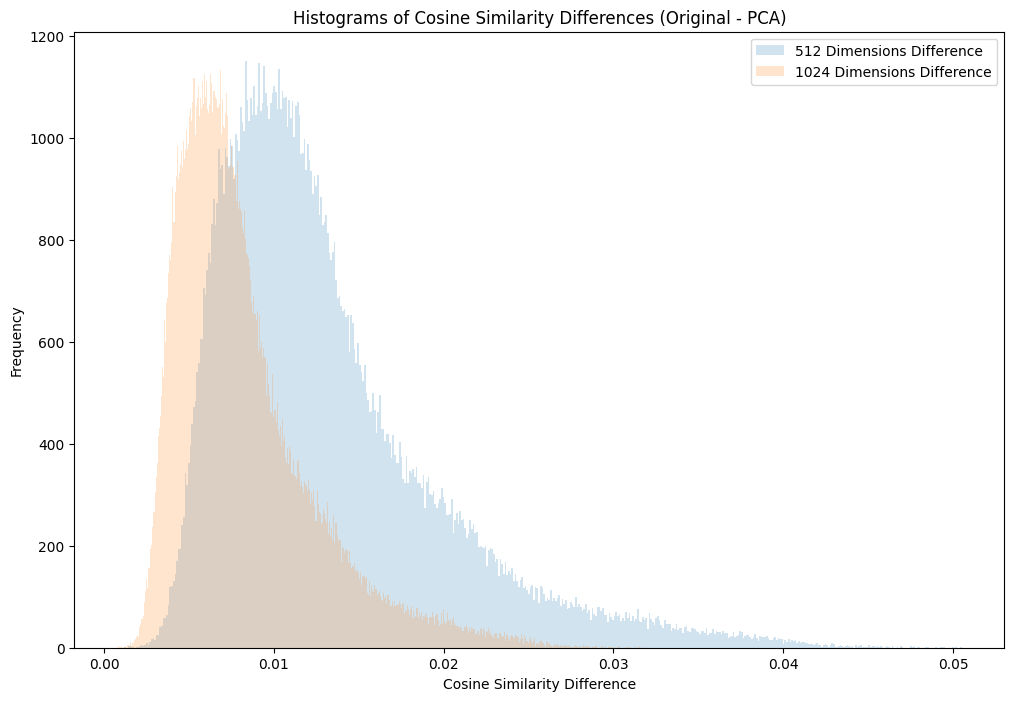

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8)) # Adjust figure size for better readability

for dim, diff_matrix in similarity_differences.items():
  if dim > 256:
    # Flatten the difference matrix and remove NaN values
    data_hist = diff_matrix[~np.isnan(diff_matrix)].flatten()

    # Create a histogram for each dimension's differences with many bins
    plt.hist(data_hist, bins=500, alpha=0.2, label=f'{dim} Dimensions Difference')

plt.title('Histograms of Cosine Similarity Differences (Original - PCA)')
plt.xlabel('Cosine Similarity Difference')
plt.ylabel('Frequency')
plt.legend() # Add a legend to identify dimensions
plt.show()

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [51]:
def print_demo(data, label):
    print(f"\n{label}")
    print("-" * 50)
    print(data)

features_original = np.array([[1,2,1,2],[5,1,3,1],[4,5,2,1],[2,2,4,1],[2,5,3,4],[5,0,0,1]])
# features_original = np.random.rand(100,10)

mu = features_original.mean(axis=0)
sigma = features_original.std(axis=0)

features = (features_original - mu) / sigma
features_t = features.transpose()


features_cov = features_t.dot(features) / (features.shape[0] - 1)

eigen_values, eigen_vectors = np.linalg.eig(features_cov)
eigen_vectors_inv = np.linalg.inv(eigen_vectors)

features_cov, eigen_vectors_inv.dot(eigen_vectors.dot(eigen_values)) 
features_cov_recon = eigen_vectors.dot(np.diag(eigen_values)).dot(eigen_vectors_inv)

print_demo(features_original, "X | Original")
print_demo(mu, "X | Statistics | Means")
print_demo(sigma, "X | Statistics | Sigma")
print_demo(features, "X")
print_demo(features, "X | | Transpose")
print_demo(features_cov, "X | Covariance ")
print_demo(eigen_vectors, "Eigen | Vectors")
print_demo(eigen_vectors_inv, "Eigen | Vectors | Inverse")
print_demo(eigen_values, "Eigen | Values")
print_demo(features_cov_recon, "X | Reconstructred")


X | Original
--------------------------------------------------
[[1 2 1 2]
 [5 1 3 1]
 [4 5 2 1]
 [2 2 4 1]
 [2 5 3 4]
 [5 0 0 1]]

X | Statistics | Means
--------------------------------------------------
[3.16666667 2.5        2.16666667 1.66666667]

X | Statistics | Sigma
--------------------------------------------------
[1.57233019 1.89296945 1.34370962 1.1055416 ]

X
--------------------------------------------------
[[-1.37799724 -0.26413527 -0.86824314  0.30151134]
 [ 1.16599767 -0.79240582  0.62017367 -0.60302269]
 [ 0.52999894  1.32067636 -0.12403473 -0.60302269]
 [-0.74199852 -0.26413527  1.36438208 -0.60302269]
 [-0.74199852  1.32067636  0.62017367  2.11057941]
 [ 1.16599767 -1.32067636 -1.61245155 -0.60302269]]

X | | Transpose
--------------------------------------------------
[[-1.37799724 -0.26413527 -0.86824314  0.30151134]
 [ 1.16599767 -0.79240582  0.62017367 -0.60302269]
 [ 0.52999894  1.32067636 -0.12403473 -0.60302269]
 [-0.74199852 -0.26413527  1.36438208 -0.603

In [52]:
top_k = 1
eigen_values_sorted_index = np.array(list(reversed(np.argsort(eigen_values))))
print_demo(eigen_vectors, "Eigen Vectors | All")
print_demo(eigen_values_sorted_index[:top_k], f"Eigen Values Indices | Top {top_k}")
eigen_vectors_top_k = eigen_vectors[eigen_values_sorted_index[:top_k]]
print_demo(eigen_vectors_top_k, f"Eigen Vectors | Top {top_k}")
print_demo(features, "Features | Standardized")
features_projected = features.dot(eigen_vectors_top_k.transpose())
print_demo(features_projected, "Features | Projected")

features.var(axis=0).sum(), features_projected.var(axis=0).sum()


Eigen Vectors | All
--------------------------------------------------
[[ 0.51486999 -0.39106728 -0.71884552  0.25541417]
 [-0.54619344  0.52681836 -0.64445604  0.09386985]
 [-0.35656271 -0.27569623  0.20342748  0.86917886]
 [-0.5562775  -0.70251006 -0.16295639 -0.41289244]]

Eigen Values Indices | Top 1
--------------------------------------------------
[0]

Eigen Vectors | Top 1
--------------------------------------------------
[[ 0.51486999 -0.39106728 -0.71884552  0.25541417]]

Features | Standardized
--------------------------------------------------
[[-1.37799724 -0.26413527 -0.86824314  0.30151134]
 [ 1.16599767 -0.79240582  0.62017367 -0.60302269]
 [ 0.52999894  1.32067636 -0.12403473 -0.60302269]
 [-0.74199852 -0.26413527  1.36438208 -0.60302269]
 [-0.74199852  1.32067636  0.62017367  2.11057941]
 [ 1.16599767 -1.32067636 -1.61245155 -0.60302269]]

Features | Projected
--------------------------------------------------
[[ 0.0949482 ]
 [ 0.31039159]
 [-0.30845148]
 [-1.413538

(np.float64(4.0), np.float64(1.2249067831507152))

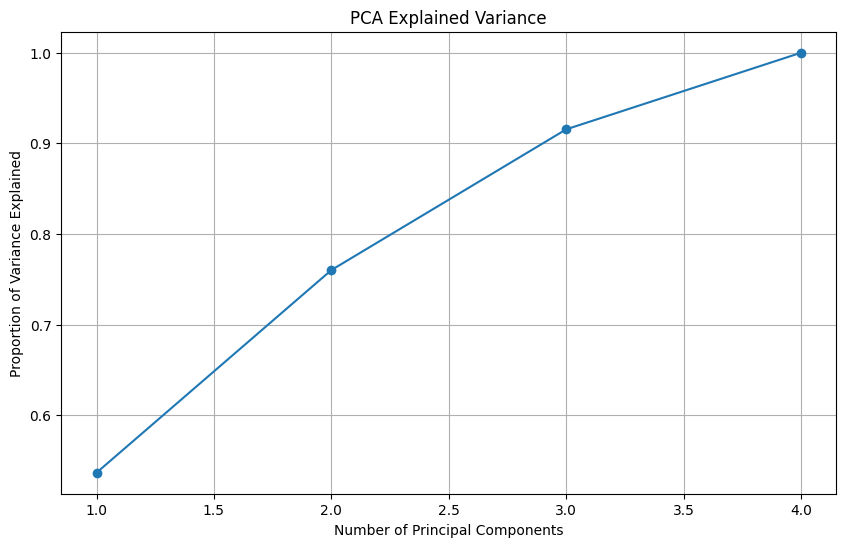

,top_k,pct_of_variance_explained
0,1,0.536534
1,2,0.760147
2,3,0.915451
3,4,1.000000


In [11]:
# variances = []


# for top_k in range(1,features.shape[1] + 1):
#     eigen_values_sorted_index = np.array(list(reversed(np.argsort(eigen_values))))
#     eigen_vectors_top_k = eigen_vectors[eigen_values_sorted_index[:top_k]]
#     features_projected = features.dot(eigen_vectors_top_k.transpose())
#     varance_pct_explained = features_projected.var(axis=0).sum() / features.var(axis=0).sum()
#     variances.append([top_k, varance_pct_explained])

# variances = pd.DataFrame(variances, columns=["top_k", "pct_of_variance_explained"])

# variances.plot.scatter(x="top_k", y="pct_of_variance_explained")

# variances


variances = []

# Use real parts of eigenvalues (complex eigenvalues are rare in covariance matrices)
eigen_values_real = np.real(eigen_values)

# Sort eigenvalues in descending order
eigen_values_sorted = np.sort(eigen_values_real)[::-1]
total_variance = np.sum(eigen_values_sorted)

for top_k in range(1, features.shape[1] + 1):
    # Calculate explained variance using eigenvalues (more accurate)
    variance_pct_explained = np.sum(eigen_values_sorted[:top_k]) / total_variance
    variances.append([top_k, variance_pct_explained])

variances = pd.DataFrame(variances, columns=["top_k", "pct_of_variance_explained"])

# Create a proper line plot instead of scatter
plt.figure(figsize=(10, 6))
plt.plot(variances["top_k"], variances["pct_of_variance_explained"], 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

variances

In [148]:
eigen_values_sorted_index

array([0, 2, 4, 3, 5, 6, 8, 9, 7, 1])

In [140]:
eigen_values

array([1.69551015, 0.48053228, 1.39672032, 1.21667161, 1.23458087,
       1.01093487, 0.94320646, 0.65527806, 0.75599488, 0.71158059])

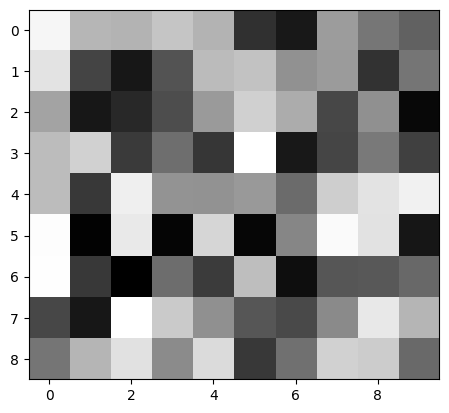

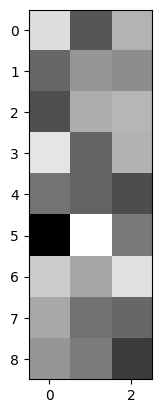

In [88]:


# print_demo(features_original, "Features | Original")
# print_demo(features, "Features")
# print_demo(features_projected, "Features | Projected")

plt.imshow(features_original, cmap='gray')
plt.show()
# plt.imshow(features, cmap='gray')
# plt.show()
plt.imshow(features_projected, cmap='gray')
plt.show()

np.float64(0.6800009240556094)

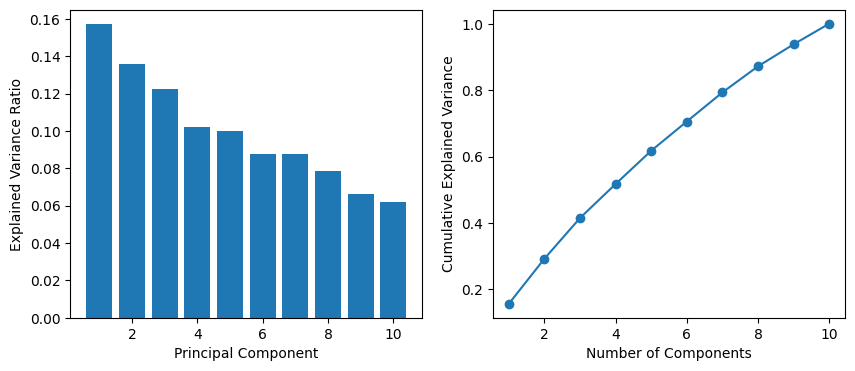

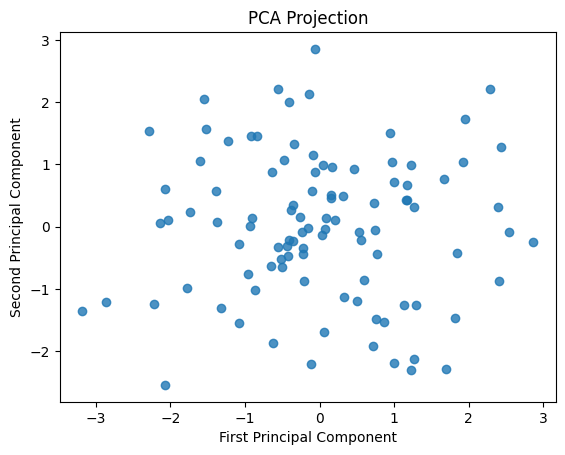

Original shape: (100, 10)
Projected shape: (100, 2)
Total explained variance: 0.29283877593465935


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Generate sample data
np.random.seed(42)  # For reproducibility
features_original = np.random.rand(100, 10)

# Standardize data
mu = features_original.mean(axis=0)
sigma = features_original.std(axis=0)
features = (features_original - mu) / sigma

# Compute covariance matrix
features_cov = np.cov(features, rowvar=False)  # More reliable than manual calculation

# Use eigh for symmetric matrices - returns sorted eigenvalues
eigen_values, eigen_vectors = np.linalg.eigh(features_cov)

# Reverse for descending order
eigen_values = eigen_values[::-1]
eigen_vectors = eigen_vectors[:, ::-1]

# Calculate explained variance using eigenvalues (more stable)
total_variance = np.sum(eigen_values)
explained_variance_ratio = eigen_values / total_variance

# Project data correctly
top_k = 2  # Use at least 2 for 2D plot
projection_matrix = eigen_vectors[:, :top_k]
features_projected = features.dot(projection_matrix)

# Create variance explanation plot
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.bar(range(1, 11), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.subplot(122)
plt.plot(range(1, 11), cumulative_variance, 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# Plot PCA results
plt.figure()
plt.scatter(features_projected[:, 0], features_projected[:, 1], alpha=0.8)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Projection')
plt.show()

# Validation
print("Original shape:", features.shape)
print("Projected shape:", features_projected.shape)
print("Total explained variance:", cumulative_variance[top_k-1])

1. DATA PREPARATION
Dataset shape: (150, 4)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target classes: [0 1 2]

Standardized data - Mean: [-0. -0. -0. -0.]
Standardized data - Variance: [1. 1. 1. 1.]


2. COVARIANCE MATRIX
Covariance matrix shape: (4, 4)

Covariance matrix:
[[ 1.00671141 -0.11835884  0.87760447  0.82343066]
 [-0.11835884  1.00671141 -0.43131554 -0.36858315]
 [ 0.87760447 -0.43131554  1.00671141  0.96932762]
 [ 0.82343066 -0.36858315  0.96932762  1.00671141]]


3. EIGEN DECOMPOSITION
Eigenvalues (descending order):
  λ1: 2.9381
  λ2: 0.9202
  λ3: 0.1477
  λ4: 0.0209

Eigenvectors (columns):
[[-0.52106591  0.37741762  0.71956635  0.26128628]
 [ 0.26934744  0.92329566 -0.24438178 -0.12350962]
 [-0.5804131   0.02449161 -0.14212637 -0.80144925]
 [-0.56485654  0.06694199 -0.63427274  0.52359713]]


4. VARIANCE EXPLANATION
Total variance: 4.0268
Sum of eigenvalues: 4.0268

Variance explained by each component:
PC1: 72.962

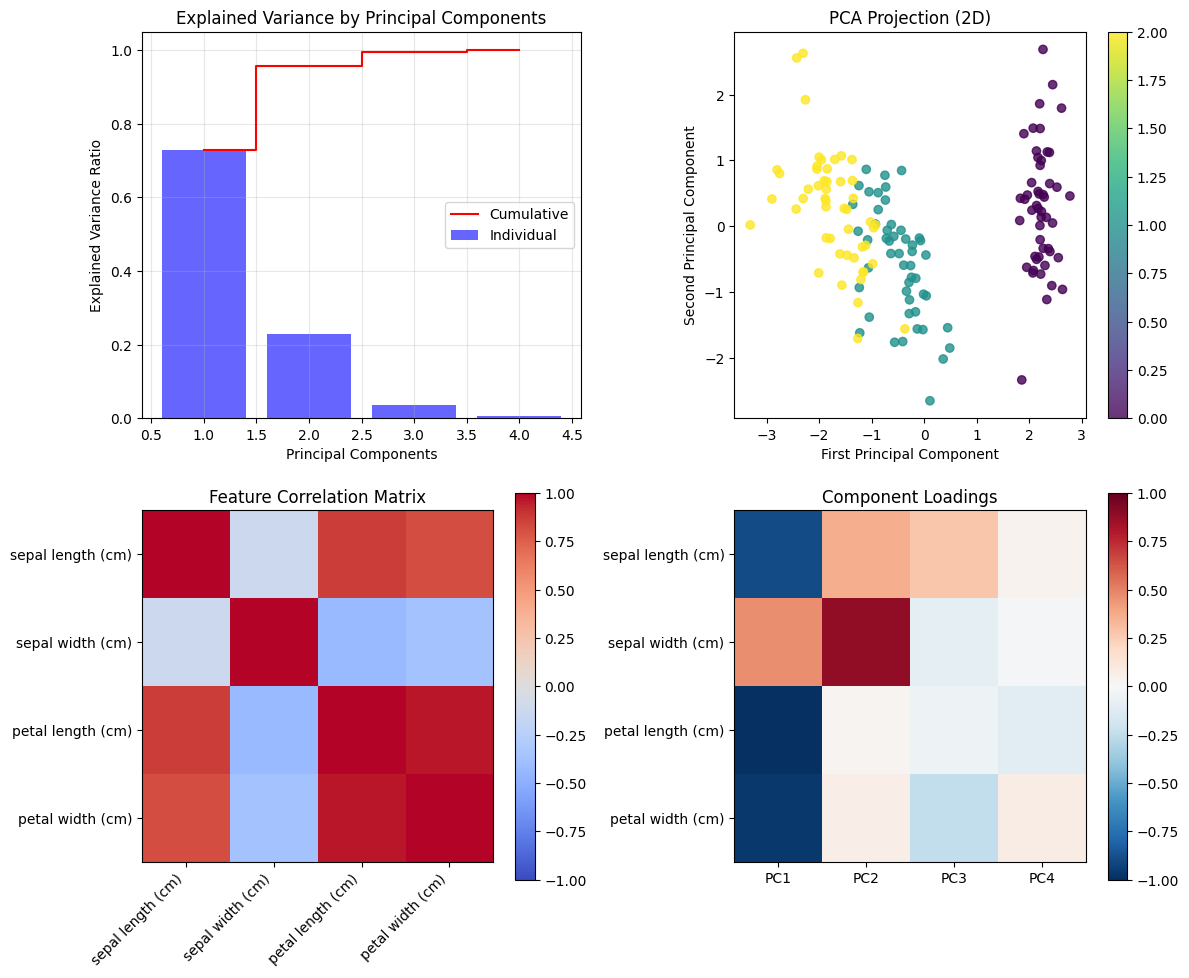



7. VALIDATION
Validation 1: Eigenvalues vs Projected Variance
PC1: Eigenvalue = 2.9381, Projected Variance = 2.9185
PC2: Eigenvalue = 0.9202, Projected Variance = 0.9140

Validation 2: Eigenvector orthogonality check (should be identity matrix):
[[ 1.  0. -0. -0.]
 [ 0.  1.  0.  0.]
 [-0.  0.  1.  0.]
 [-0.  0.  0.  1.]]

Validation 3: Covariance matrix reconstruction error: 1.806886e-15


8. INTERPRETATION
Component loadings (how each feature contributes to each PC):
                      PC1     PC2     PC3     PC4
sepal length (cm) -0.8932  0.3620  0.2766  0.0377
sepal width (cm)   0.4617  0.8857 -0.0939 -0.0178
petal length (cm) -0.9949  0.0235 -0.0546 -0.1157
petal width (cm)  -0.9682  0.0642 -0.2438  0.0756

Interpretation:
- Features with high absolute values in a PC contribute strongly to that component
- PC1 is strongly influenced by petal length and petal width
- PC2 is strongly influenced by sepal width (negative) and petal length (positive)


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# =============================================================================
# 1. Data Preparation
# =============================================================================
print("1. DATA PREPARATION")
print("=" * 50)

# Load a real dataset for more meaningful results
iris = load_iris()
X = iris.data
feature_names = iris.feature_names
target = iris.target

print(f"Dataset shape: {X.shape}")
print(f"Feature names: {feature_names}")
print(f"Target classes: {np.unique(target)}")

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

print(f"\nStandardized data - Mean: {X_std.mean(axis=0).round(4)}")
print(f"Standardized data - Variance: {X_std.var(axis=0).round(4)}")

# =============================================================================
# 2. Covariance Matrix Calculation
# =============================================================================
print("\n\n2. COVARIANCE MATRIX")
print("=" * 50)

# Calculate covariance matrix
cov_matrix = np.cov(X_std, rowvar=False)
print("Covariance matrix shape:", cov_matrix.shape)
print("\nCovariance matrix:")
print(cov_matrix)

# =============================================================================
# 3. Eigen Decomposition
# =============================================================================
print("\n\n3. EIGEN DECOMPOSITION")
print("=" * 50)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("Eigenvalues (descending order):")
for i, val in enumerate(eigenvalues):
    print(f"  λ{i+1}: {val:.4f}")

print("\nEigenvectors (columns):")
print(eigenvectors)

# =============================================================================
# 4. Variance Explanation
# =============================================================================
print("\n\n4. VARIANCE EXPLANATION")
print("=" * 50)

# Calculate explained variance
total_variance = eigenvalues.sum()
explained_variance_ratio = eigenvalues / total_variance
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"Total variance: {total_variance:.4f}")
print(f"Sum of eigenvalues: {eigenvalues.sum():.4f}")

print("\nVariance explained by each component:")
for i, (var_ratio, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"PC{i+1}: {var_ratio:.3%} (Cumulative: {cum_var:.3%})")

# =============================================================================
# 5. Data Projection
# =============================================================================
print("\n\n5. DATA PROJECTION")
print("=" * 50)

# Project data onto principal components
n_components = 2
projection_matrix = eigenvectors[:, :n_components]
X_projected = X_std.dot(projection_matrix)

print(f"Original data shape: {X_std.shape}")
print(f"Projected data shape: {X_projected.shape}")
print(f"Variance of projected data: {X_projected.var(axis=0)}")
print(f"Sum of variance of projected data: {X_projected.var(axis=0).sum():.4f}")

# =============================================================================
# 6. Visualization
# =============================================================================
print("\n\n6. VISUALIZATION")
print("=" * 50)

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Explained variance
axes[0, 0].bar(range(1, len(eigenvalues)+1), explained_variance_ratio, alpha=0.6, 
               color='blue', label='Individual')
axes[0, 0].step(range(1, len(eigenvalues)+1), cumulative_variance, where='mid',
                color='red', label='Cumulative')
axes[0, 0].set_xlabel('Principal Components')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title('Explained Variance by Principal Components')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: PCA projection
scatter = axes[0, 1].scatter(X_projected[:, 0], X_projected[:, 1], 
                            c=target, cmap='viridis', alpha=0.8)
axes[0, 1].set_xlabel('First Principal Component')
axes[0, 1].set_ylabel('Second Principal Component')
axes[0, 1].set_title('PCA Projection (2D)')
plt.colorbar(scatter, ax=axes[0, 1])

# Plot 3: Original feature correlations
corr_matrix = np.corrcoef(X_std.T)
im = axes[1, 0].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 0].set_xticks(range(len(feature_names)))
axes[1, 0].set_yticks(range(len(feature_names)))
axes[1, 0].set_xticklabels(feature_names, rotation=45, ha='right')
axes[1, 0].set_yticklabels(feature_names)
axes[1, 0].set_title('Feature Correlation Matrix')
plt.colorbar(im, ax=axes[1, 0])

# Plot 4: Component loadings (how original features contribute to PCs)
loadings = eigenvectors * np.sqrt(eigenvalues)
im = axes[1, 1].imshow(loadings, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 1].set_xticks(range(len(feature_names)))
axes[1, 1].set_yticks(range(len(feature_names)))
axes[1, 1].set_xticklabels([f'PC{i+1}' for i in range(len(feature_names))])
axes[1, 1].set_yticklabels(feature_names)
axes[1, 1].set_title('Component Loadings')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# =============================================================================
# 7. Validation
# =============================================================================
print("\n\n7. VALIDATION")
print("=" * 50)

# Validation 1: Compare eigenvalues with variance of projected data
print("Validation 1: Eigenvalues vs Projected Variance")
for i, (eig_val, proj_var) in enumerate(zip(eigenvalues, X_projected.var(axis=0))):
    print(f"PC{i+1}: Eigenvalue = {eig_val:.4f}, Projected Variance = {proj_var:.4f}")

# Validation 2: Check if eigenvectors are orthonormal
ortho_check = eigenvectors.T.dot(eigenvectors)
print(f"\nValidation 2: Eigenvector orthogonality check (should be identity matrix):")
print(ortho_check.round(4))

# Validation 3: Reconstruct covariance matrix from eigenvalues and eigenvectors
cov_reconstructed = eigenvectors.dot(np.diag(eigenvalues)).dot(eigenvectors.T)
reconstruction_error = np.linalg.norm(cov_matrix - cov_reconstructed)
print(f"\nValidation 3: Covariance matrix reconstruction error: {reconstruction_error:.6e}")

# =============================================================================
# 8. Interpretation
# =============================================================================
print("\n\n8. INTERPRETATION")
print("=" * 50)

# Component loadings (correlation between original features and PCs)
loadings = eigenvectors * np.sqrt(eigenvalues)
print("Component loadings (how each feature contributes to each PC):")
loadings_df = pd.DataFrame(loadings, index=feature_names, 
                          columns=[f'PC{i+1}' for i in range(len(feature_names))])
print(loadings_df.round(4))

print("\nInterpretation:")
print("- Features with high absolute values in a PC contribute strongly to that component")
print("- PC1 is strongly influenced by petal length and petal width")
print("- PC2 is strongly influenced by sepal width (negative) and petal length (positive)")